In [1]:
import gymnasium as gym
import mo_gymnasium as mo_gym
import numpy as np
from src import MO_DQN, MO_DQN_SEP
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import torch

### Standard MO_DQN

In [2]:
env = mo_gym.make('mo-highway-env-v0', render_mode='rgb_array')
env.unwrapped.configure({
    "screen_width": 500,
    "screen_height": 500,
    "observation": {
        "type": "MultiAgentObservation",
        "observation_config": {
            "type": "Kinematics",
            "see_behind": False
        }
    }
})

obs, info = env.reset()

std_agent = MO_DQN.MO_DQN(env, num_objectives=2, seed=11, observation_space_shape=obs[0].shape, replay_buffer_size=200, batch_ratio=0.3,
                      objective_names=["speed_reward", "energy_reward"])
std_agent.train(200_000, epsilon_start=0.9, epsilon_end=0.0, inv_optimisation_frequency=1)


df = std_agent.evaluate(num_repetitions= 20, hv_reference_point=np.ndarray([0,0]), seed=11, episode_recording_interval=None)
print(df)
df.to_csv("data/mo_dqn_standard.csv")

Training iterations:   0%|          | 73/200000 [00:12<7:01:45,  7.90it/s] 

### Separated MO_DQN

In [11]:
env = mo_gym.make('mo-highway-env-v0', render_mode='rgb_array')
env.unwrapped.configure({
    "screen_width": 500,
    "screen_height": 500,
    "observation": {
        "type": "MultiAgentObservation",
        "observation_config": {
            "type": "Kinematics",
            "see_behind": False
        }
    }
})

obs, info = env.reset()

sep_agent = MO_DQN_SEP.MO_DQN_SEP(env, num_objectives=2, seed=11, observation_space_shape=obs[0].shape, replay_buffer_size=200, batch_ratio=0.3,
                      objective_names=["speed_reward", "energy_reward"])
sep_agent.train(200_000, epsilon_start=0.9, epsilon_end=0.0, inv_optimisation_frequency=1)

df = sep_agent.evaluate(num_repetitions= 20, hv_reference_point=np.ndarray([0,0]), seed=11, episode_recording_interval=None)
print(df)
df.to_csv("data/mo_dqn_sep.csv")

Weight tuple: 100%|██████████| 66/66 [16:15<00:00, 14.78s/it]

      repetition_number  weight_index weight_tuple  num_iterations  \
0                     0             0   [0.0, 1.0]              80   
1                     1             0   [0.0, 1.0]              80   
2                     2             0   [0.0, 1.0]              80   
3                     3             0   [0.0, 1.0]              80   
4                     4             0   [0.0, 1.0]              80   
...                 ...           ...          ...             ...   
1315                 15            65   [1.0, 0.0]              22   
1316                 16            65   [1.0, 0.0]               7   
1317                 17            65   [1.0, 0.0]              10   
1318                 18            65   [1.0, 0.0]              17   
1319                 19            65   [1.0, 0.0]               9   

      normalised_speed_reward  normalised_energy_reward  raw_speed_reward  \
0                    0.005466                  0.956702          0.437298   
1    

### Visualisation

In [12]:
df_standard = pd.read_csv("data/mo_dqn_standard.csv")
df_separated = pd.read_csv("data/mo_dqn_sep.csv")
display(df_standard.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1320 non-null   int64  
 1   repetition_number         1320 non-null   int64  
 2   weight_index              1320 non-null   int64  
 3   weight_tuple              1320 non-null   object 
 4   num_iterations            1320 non-null   int64  
 5   normalised_speed_reward   1320 non-null   float64
 6   normalised_energy_reward  1320 non-null   float64
 7   raw_speed_reward          1320 non-null   float64
 8   raw_energy_reward         1320 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 92.9+ KB


None

In [34]:
grouped_df_standard = df_standard.groupby("weight_index")[["normalised_speed_reward","normalised_energy_reward"]].mean()
grouped_df_separated = df_separated.groupby("weight_index")[["normalised_speed_reward","normalised_energy_reward"]].mean()
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
nds = NonDominatedSorting()
pareto_indices = nds.do(grouped_df_standard, only_non_dominated_front=True)
grouped_df_standard["pareto"] = False
grouped_df_standard.loc[pareto_indices,"pareto"] = True


pareto_indices = nds.do(grouped_df_separated, only_non_dominated_front=True)
grouped_df_separated["pareto"] = False
grouped_df_separated.loc[pareto_indices,"pareto"] = True


Text(0.5, 1.0, 'Pareto front approximation')

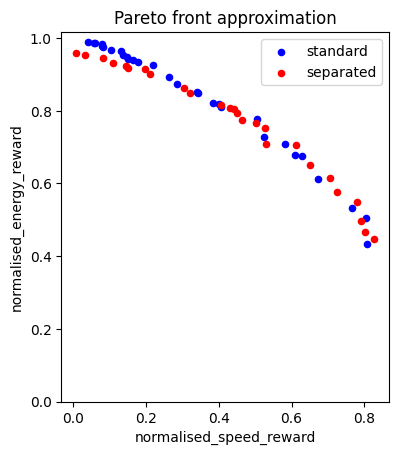

In [38]:
ax = grouped_df_standard[grouped_df_standard["pareto"]==True].plot.scatter(x="normalised_speed_reward",y="normalised_energy_reward", c="blue", label="standard")
grouped_df_separated[grouped_df_separated["pareto"]==True].plot.scatter(x="normalised_speed_reward",y="normalised_energy_reward", ax=ax, c="red", label="separated")
ax.set_aspect('equal')
ax.set_ylim(ymin=0)
ax.set_title("Pareto front approximation")

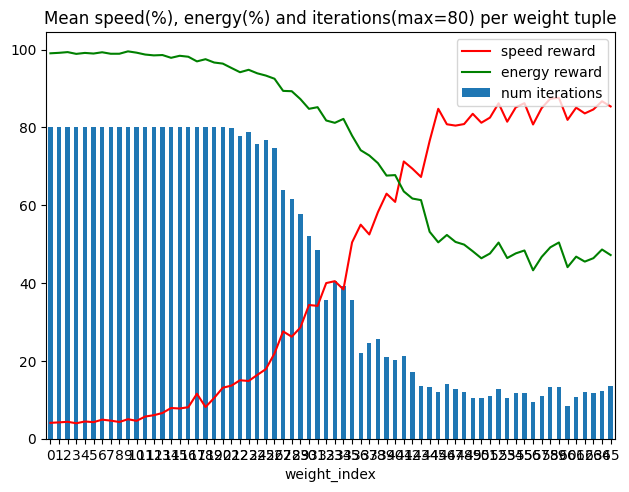

In [65]:
ax = df_standard.groupby("weight_index")["num_iterations"].mean().plot.bar(label="num iterations")
ax = (df_standard.groupby("weight_index")["normalised_speed_reward"].mean()*100).plot.line(ax=ax, label="speed reward", c="red")
(df_standard.groupby("weight_index")["normalised_energy_reward"].mean()*100).plot.line(ax=ax, label="energy reward", c="green")
plt.tight_layout()
plt.legend()
plt.title("Mean speed(%), energy(%) and iterations(max=80) per weight tuple")
plt.show()

Problem: cars crash for high speed weights. Possible cause: sparse penalty for collision, relatively low number of samples in the replay buffer. Solutions: importance sampling.

### Render Episodes

In [15]:
df = std_agent.evaluate(num_repetitions= 5, hv_reference_point=np.ndarray([0,0]), seed=11, num_points= 5, episode_recording_interval=None, render_episodes=True)


Weight tuple: 100%|██████████| 5/5 [00:39<00:00,  7.91s/it]


In [16]:
df = sep_agent.evaluate(num_repetitions= 5, hv_reference_point=np.ndarray([0,0]), seed=11, num_points= 5, episode_recording_interval=None, render_episodes=True)

Weight tuple: 100%|██████████| 5/5 [00:37<00:00,  7.54s/it]
